In [1]:
from fastai.vision.all import *

### 데이터 준비

In [2]:
path = untar_data(URLs.PASCAL_2007)
# PASCAL은 분류된 물체가 하나 이상인 데이터셋이야.

df = pd.read_csv(path/'train.csv')
df.head()
# 판다스는 csv파일을 열고 살펴보는 기능이야.
# PASCAL은 이미지파일과 레이블을 csv파일로 제공해.

### 데이터셋츠 만들기
- dataset: 단일 파일들이 (독립, 종속) 튜플로 묶인 것
- dataloader: 미니 배치로 만든 것. (여러 독립변수들, 여러 종속변수들)
- datasets: 학습용 + 검증용 dataset
- dataloaders: 학습용 + 검증용 dataloader
- 데이터셋츠를 만들면서 살펴본 후에 배치로 묶어준 데이터로더를 만드는 순서로 할거야.

In [113]:
dblock = DataBlock()
# 디폴트값으로 설정된 데이터블록(템플릿)을 만들면서 살펴본 후, 데이터블록을 수정할거야.

dsets = dblock.datasets(df)
dsets.train[0]

(fname                            005672.jpg
 labels      bottle chair person diningtable
 is_valid                               True
 Name: 2847, dtype: object,
 fname                            005672.jpg
 labels      bottle chair person diningtable
 is_valid                               True
 Name: 2847, dtype: object)

문제는.
1. fname -> 독립변수부분(이미지경로)만 떼어내야하고, 완전한 경로로 출력하도록 해야해.
2. labels -> 종속변수부분(레이블)만 떼어내야하고, 공백으로 구분된 두 레이블 모두 출력하도록 해야해.
3. is_valid -> 학습용/검증용 데이터를 분리하는 함수 필요해.
4. blocks -> 단일 레이블 분류는 CategoryBlock을 사용해. 레이블을 적당한 정수로 표현하는 블록이지. 지금은 다중 레이블 분류이기 때문에 MultiCategoryBlock을 사용해. 레이블을 원핫인코딩으로 표현하는 블록이야.

In [107]:
def get_x(r):
    return path/'train'/r['fname']
# 여기서 r은 데이터프레임의 각 행을 의미해.
# df의 각 행에서 fname만 색인하는 거야.

def get_y(r):
    return r['labels'].split(' ')

def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid
# trian은 df에서 is_valid=False인 인덱스만 리스트로 만든 거야. [0,1,2]
# valid은 df에서 is_valid=True인 인덱스만 리스트로 만든 거야. [3,4,5]

In [77]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                  item_tfms = RandomResizedCrop(128, min_scale=0.35))

dsets = dblock.datasets(df)
dsets.train[0] 

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

### 데이터로더 만들기
- 데이터블록(템플릿)에 최종적으로 데이터프레임을 넣어주어서 미니배치들로 구성된 데이터로더를 만들어.

In [78]:
dls = dblock.dataloaders(df)

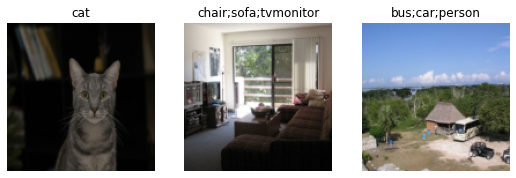

In [79]:
dls.show_batch(nrows=1, ncols=3)

### 러너 만들기
- 러너에는 (데이터로더, 모델, 옵티마이저, 손실함수)가 필요해.
- 이중 손실함수를 정해줘야해.

In [103]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

손실함수 - 이진교차엔트로피
- **시그모이드**는 실수값을 받고 0~1 사이값. 즉 확률로 뱉어. **2.02 -> 0.9**
- **음수 로그**는 오른쪽 아래로 하강하는 그래프야. x값이 클수록 작은값을 뱉어. 그래서 손실값으로 내보내기 좋아. **-log(0.9) = 0.105**
- 시그모이드를 취한 후, 음수 로그를 취하는 방법이야.
- Fastai에는 자동으로 적절한 함수를 지정하기 때문에 이진교차엔트로피를 손실함수로 명시할 필요는 없어.

In [105]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True): # 기본 임계값은 0.5야.
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

정확도함수 - 예를 들어
- 모델예측값에 시그모이드를 적용한 값이 **(0.9 0.1 0.2 0.8)**
- 타겟이 **(1 0 0 1)** 이면
- 예측값이 **임계값**을 넘으면 1로, 안넘으면 0으로 간주하여서 타겟이랑 비교해야해.
- 따라서 정확한 임계값을 정하는 게 중요해.
- 0.1, 0.99, 0.6 등 다양한 임계값을 사용해서 최적값을 찾아야해.

In [112]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.6))
learn.fine_tune(3)

# partial: 함수의 일부 인자를 고정하는 함수야.
# accuracy_multi함수의 인자인 thresh를 고정해.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.893283,0.627560,0.779104,00:11


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.664843,0.486959,0.879104,00:17
1,0.529650,0.317699,0.947948,00:15
2,0.425674,0.277633,0.956653,00:16
